## AcceleGrad vs UnixGrad Analysis

## Import the libraries

In [1]:
import os
import sys
import numpy as np
from scipy import sparse 
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import preprocessing
from sklearn.utils import shuffle
from tqdm.notebook import tqdm


module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
print("Main Directory: ", module_path)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Main Directory:  /Users/francescomandru/Desktop/Projects/Optimization


## Functions

In [121]:
def load_adult_data(path):
    df = pd.read_csv(os.path.join(module_path,"datasets/adult.csv"))
    df['workclass'] = df['workclass'].astype('category')
    df['education'] = df['education'].astype('category')
    df['marital.status'] = df['marital.status'].astype('category')
    df['occupation'] = df['occupation'].astype('category')
    df['relationship'] = df['relationship'].astype('category')
    df['race'] = df['race'].astype('category')
    df['sex'] = df['sex'].astype('category')
    df['native.country'] = df['native.country'].astype('category')
    df['income'] = df['income'].astype('category')

    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    features = np.array(df)[:,:-1]
    
    # normalization
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)
    
    b = np.ones(len(features)).reshape(-1,1)
    features = np.hstack((features,b))
    
    # labels
    labels = np.array(df)[:,-1]
    labels[labels==0] = -1
    labels = labels.reshape((-1,1))

    return shuffle(features, labels)  

def load_data( path ):

    # import
    data = pd.read_csv( path, delimiter=',')
    data = data.drop('id', axis=1)
    data = data.drop('Unnamed: 32', axis=1)
    data['diagnosis'] = np.array(data['diagnosis'].map(lambda x: 1 if x=='M' else -1))
    
    features = np.array(data)[:,1:]
    
    # normalization
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)
    
    b = np.ones(len(features)).reshape(-1,1)
    features = np.hstack((features,b))
    
    # labels
    labels = np.array(data)[:,0]
    labels[labels==0] = -1
    labels = labels.reshape((-1,1))

    return shuffle(features, labels)

def gen_least_square_data(n, d, R):
    """Generate a sintethic dataset which solution
    is given by a least square problem minimization.
    Input:
        n = number of samples
        d = dimension of dataset
        R = Diameter of the ball 
    Output:
        x_star = Optimal weights 
        f_star = minimum achievable error
        A = Matrix
        b = vector
    """
    mean = np.zeros(d)
    sigma = 1
    cov = (sigma**2)*np.eye(d)
    x_mus = np.random.normal(0,1,d).reshape(-1,1)
    eps = np.random.normal(0,1e-03,n).reshape(-1,1)
    
    A = np.random.multivariate_normal(mean, cov, n)
    
    b = np.dot(A,x_mus) + eps

    x_star = np.dot( np.dot( np.linalg.inv( np.dot(A.T, A) ), A.T), b )
    if(np.linalg.norm(x_star) > R):
        x_proj = gradient_projection(x_star, d)
    f_star = (1/2*n)*np.linalg.norm(np.dot(A, x_star) - b, ord=2)
    
    return A, b, x_star, f_star

def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    return (np.count_nonzero( (y_pred - y_test) == 0 ) / len(y_pred))*100

def batch_gen(data,labels,batch_size):
    num_batches = len(data)//batch_size
    return np.split(data[:num_batches*batch_size], num_batches, axis=0), np.split(labels[:num_batches*batch_size], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def compute_grad(w, lamb, x, y):
    w = w[:,0]
    yx = y*x
    yxw = yx.dot(w)
    compare_result= np.maximum(0, 1-yxw)
    part1 = -2/len(y)*compare_result.dot(yx)
    part2 = 2*lamb*w      
    return (part1+part2)[:, np.newaxis]

def squared_hinge_loss(w, lamb, x, y):
    w = w[:,0]
    return 1/len(y) * (np.sum(
        (np.maximum(0, 1-((y*x).dot(w)))**2)))\
        + lamb * np.linalg.norm(w)**2

def accelegrad(weights,
                  x_train,
                  y_train,
                  x_test,
                  y_test,
                  D=1,
                  G=0,
                  batch_size = 5,
                  lamb=0.01,
                  max_iter=100):
    
    loss_hist = []
    accuracy_hist = []
    
    #x0 = gradient_projection(weights, D)
    x0 = weights

    xt = yt = zt = ybar = x0
    S1 = 0
    S2 = 0
    train_batches, train_labels = batch_gen(x_train, y_train, batch_size)
    
    for t in range(max_iter+1):
        
        #prediction = predict(x_test, ybar)
        #accuracy_hist.append( get_accuracy( prediction, y_test) )
        
        batch, label = random_batch_selection(train_batches, train_labels)
        
        alphat = np.maximum( 0.25*(t+1), 1 )
        taut = 1/alphat
        
        # Update
        xt = taut * zt + (1-taut)*yt
        
        # Compute the subgradient
        gt = compute_grad(xt, lamb, batch, label)
        
        ng = np.linalg.norm(gt)

        S1 = S1 + (alphat*ng)**2
        
        etat = D/np.sqrt( 2*(G**2 + S1) )
        zt = gradient_projection(zt - alphat*etat*gt,D)
        
        yt = xt - etat*gt
        
        # Averaged
        S2 = S2 + alphat
        weight = alphat/S2
        ybar =  (1 - weight)*ybar + weight*yt
        
        #loss = squared_hinge_loss(ybar, lamb, batch, label)
        loss = squared_hinge_loss(ybar, lamb, x_train, y_train)
        loss_hist.append(loss)
        
        prediction = predict(x_test, ybar)
        accuracy_hist.append( get_accuracy( prediction, y_test) )
    
    return loss_hist, accuracy_hist, ybar


def unixGrad(weights,
             x_train,
             y_train,
             x_test,
             y_test,
             batch_size = 5,
             D=1,
             lamb=0.01,
             max_iter=100):
    
    
    loss_hist = []
    accuracy_hist = []
    
    #x0 = gradient_projection(weights, np.sqrt(D))
    x0 = weights

    yt = x0

    # cumulative sum of denominator of etat (learning rate)
    S1 = 1
    
    # cumulative sum of alpha
    S2 = 0
    
    # cumulative alpha_i*x_i
    S3 = 0
    
    train_batches, train_labels = batch_gen(x_train, y_train, batch_size)
    
    for t in range(1,max_iter+1):
        
        # Randomly select a batch
        batch, label = random_batch_selection(train_batches, train_labels)
        
        #prediction = predict(x_test, xtbar)
        #accuracy_hist.append( get_accuracy( prediction, y_test) )
        
        # Compute alphat=1
        alphat = t
        
        # Update cumulative alphat S2=0+1=1
        S2 = S2 + alphat
        #weight = alphat/S2
        
        # Update zbar = yt/1 = yt = init(yt) = zeros
        ztbar =  ( alphat*yt + S3 ) / S2
        #ztbar = weight*yt + (1-weight)*ztbar
        
        # Compute gradient in zbar
        Mt = compute_grad( ztbar, lamb, batch, label  )
        
        # Compute etat (lag-one-behind)
        #etat = 2*np.sqrt(D) / np.sqrt(1 + S1)
        etat = 2*D / np.sqrt(1 + S1)
        
        # Mirror Prox (MP) update (PRIMARY SEQUENCE)
        #xt = ( 0.5*etat ) * ( 2*yt - alphat*Mt )
        xt = yt - 0.5*alphat*etat*Mt 
        
        # Update xbar
        
        #xtbar =  (1 - weight)*xtbar + weight*xt
        xtbar = (1/S2)* ( alphat*xt + S3 )
        
        # Compute gradient in xbar 
        gt = compute_grad( xtbar, lamb, batch, label  )
        
        # Mirror Prox update (SECONDARY SEQUENCE)
        #yt = ( 0.5*etat ) * ( 2*yt - alphat*gt )
        yt = yt - 0.5*alphat*etat*gt 
        
        # Update S3
        S3 = S3 + alphat*xt

        # update S1
        nd = np.linalg.norm(gt - Mt)   
        S1 = S1 + (alphat*nd)**2
        
        # Compute the training loss
        loss = squared_hinge_loss(xtbar, lamb, x_train, y_train)
        loss_hist.append(loss)
        
        prediction = predict(x_test, xtbar)
        accuracy_hist.append( get_accuracy( prediction, y_test) )

    return loss_hist, accuracy_hist, xtbar

## Load Data

In [122]:
X, y = load_data( os.path.join(module_path,"datasets/data.csv") )
#X, y = load_adult_data( os.path.join(module_path,"datasets/adult.csv") )
print("Dataset shape: ", X.shape)
print("Labels shape: ", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("TRAIN len: ", len(X_train))
print("TEST len: ", len(X_test))
#initialize initial weights as a sparse matrix. 
weights_initial = np.random.rand(1,X.shape[1]).T
print("Weights shape: ", weights_initial.shape)

Dataset shape:  (569, 31)
Labels shape:  (569, 1)
TRAIN len:  455
TEST len:  114
Weights shape:  (31, 1)


## Gridsearch 

In [ ]:
def printConfiguration( config ):
    print('\n'.join('- {}: {}'.format(*k) for k in list(zip(config.keys(), config.values())) ))
    print('\n')
    
max_iter = 10000

best_acc_grad = 0
best_conf_grad = 0
    
tuned_parameters = [{'diameter': [10],#[0.01,0.1,10,100,1000], 
                     'lambda': [1e-3, 1e-2, 1e-1, 1, 10, 100]
                    }]

grid = ParameterGrid( tuned_parameters )


for i,params in enumerate(grid):
        
    #print('\n\n --- Config. number %u ----------' %(i))
    #printConfiguration( params )
    
    losses = []
    accs = []
    
    for i in range(5):

    
        weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T

        loss, acc, y_bar = accelegrad(weights_initial,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    D=params['diameter'],
                                    G=0,
                                    lamb=params['lambda'],
                                    max_iter=max_iter)
    
    
        losses.append(loss)
        accs.append(acc)
    
    
    mean_loss = np.mean(losses,axis=0)
    mean_acc = np.mean(accs, axis=0)    
    
    if(mean_acc[-1] > best_acc_grad):
        #print("New Accelegrad acc: ", mean_acc[-1])
        best_acc_grad = mean_acc[-1]
        best_conf_grad = params
        
print('\n\n --- BEST Config. AcceleGrad ----------')
printConfiguration( best_conf_grad )

best_acc_unix = 0
best_conf_unix = 0

for i,params in enumerate(grid):
        
    #print('\n\n --- Config. number %u ----------' %(i))
    #printConfiguration( params )
    
    losses = []
    accs = []
    
    for i in range(5):

    
        weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T

        loss, acc, y_bar = unixGrad(weights_initial,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    D=params['diameter'],
                                    lamb=params['lambda'],
                                    max_iter=max_iter)
    
    
        losses.append(loss)
        accs.append(acc)
    
    
    mean_loss = np.mean(losses,axis=0)
    mean_acc = np.mean(accs, axis=0)    
    
    if(mean_acc[-1] > best_acc_unix):
        #print("New UnixGrad acc: ", mean_acc[-1])
        best_acc_unix = mean_acc[-1]
        best_conf_unix = params
        
print('\n\n --- BEST Config. UnixGrad ----------')
printConfiguration( best_conf_unix )

## Comparison with best params.

In [145]:
accelegrad_D = 10
accelegrad_L = 0.001

unixgrad_D = 1
unixgrad_L = 2

In [146]:
max_iter = 100

losses = []
accs = []

losses_ug = []
accs_ug = []
for i in range(5):
    #weights_initial = np.random.rand(1,X_train.shape[1]).T
    #weights_initial = np.zeros((X_train.shape[1],1))
    weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T
    #weights_initial = gradient_projection(weights_initial, D)

    loss, acc, y_bar = accelegrad(weights_initial,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                D=accelegrad_D,
                                G=0,
                                lamb=accelegrad_L,
                                max_iter=max_iter)
    
    loss_ug, acc_ug, y_bar_ug = unixGrad(weights_initial,
                                         X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         D=unixgrad_D,
                                         lamb=unixgrad_L,
                                         max_iter=max_iter)
    
    #plt.plot(loss, alpha=0.3, c='tab:blue')
    
    losses.append(loss)
    accs.append(acc)
    
    losses_ug.append(loss_ug)
    accs_ug.append(acc_ug)
    
    
mean_loss = np.mean(losses,axis=0)
mean_acc = np.mean(accs, axis=0)


mean_loss_ug = np.mean(losses_ug, axis=0)
mean_acc_ug = np.mean(accs_ug, axis=0)

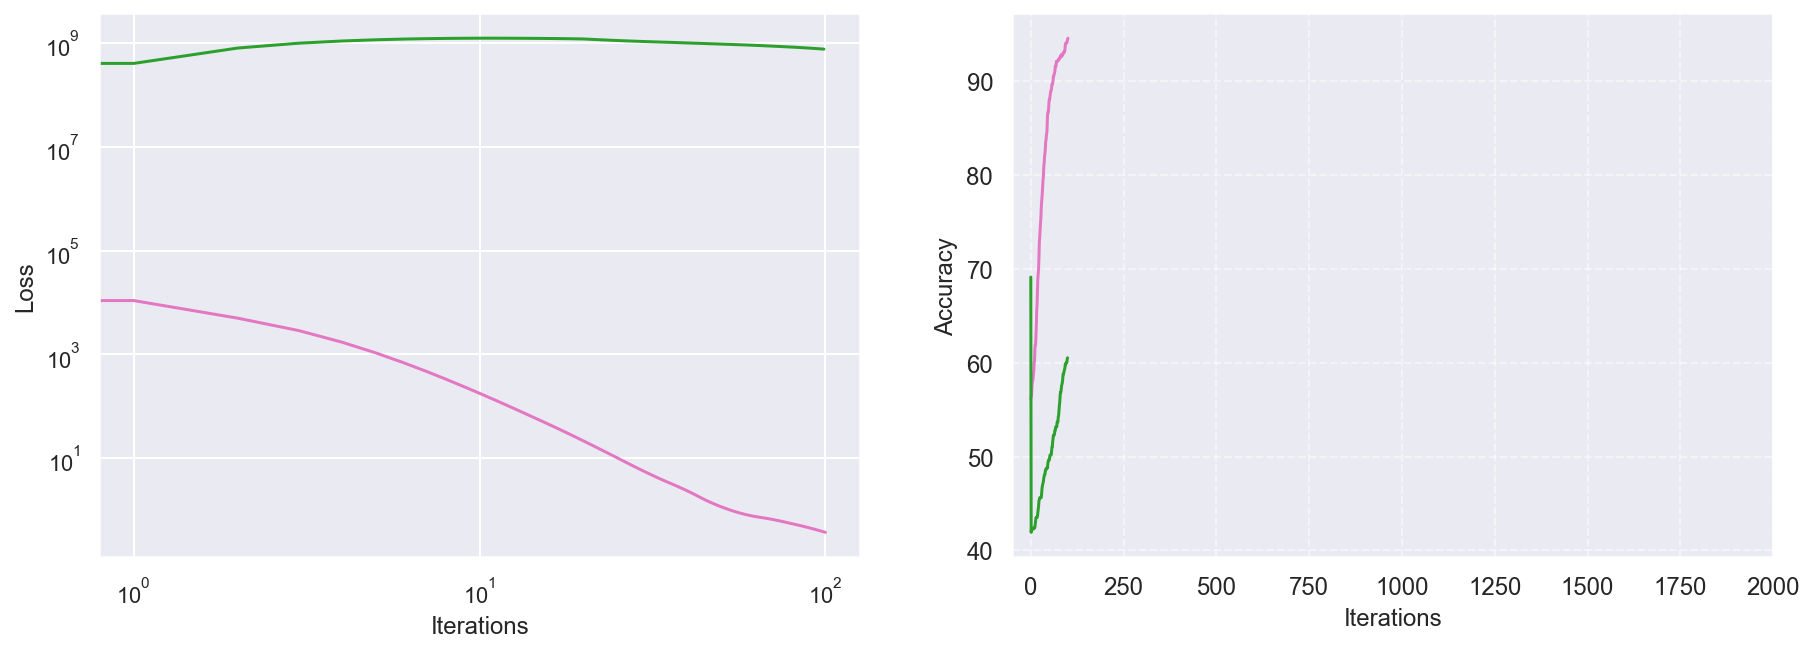

In [147]:
sns.set_theme()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(mean_loss, c='tab:pink')
ax1.plot(mean_loss_ug, c='tab:green')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
#ax1.set_xlim([-50,20])
#ax1.set_ylim([0,1000000])

ax2.plot(mean_acc, c='tab:pink')
ax2.plot(mean_acc_ug, c='tab:green')
ax2.set_xlim([-50,2000])
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")

plt.grid(which='both', ls="--", alpha=0.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

## Further analyses 

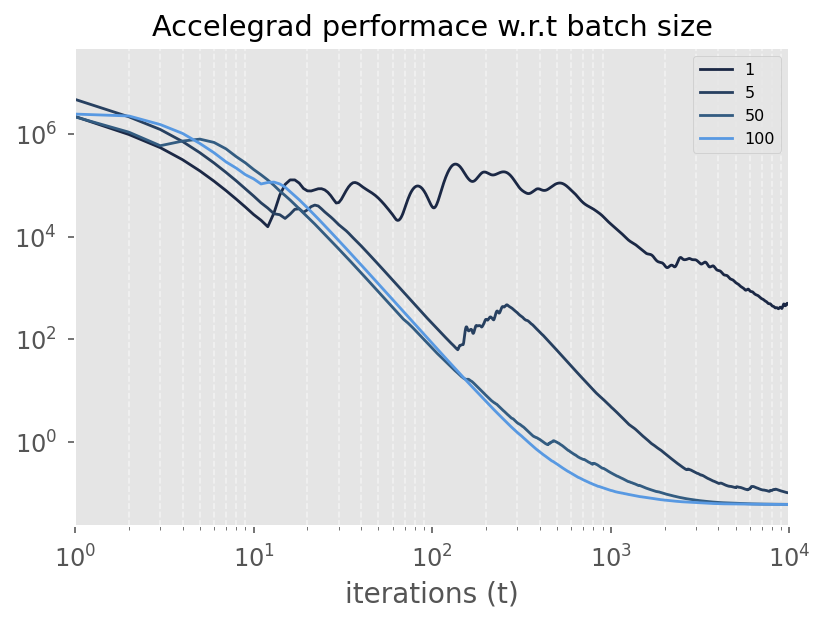

In [65]:
max_iter = 10000

trials = 1
batches = [1,5,50,100]

losses = []
accs = []

for i in range(len(batches)):
    b_losses = np.zeros((5,max_iter+1))
    b_accs = np.zeros((5,max_iter+1))
    for j in range(trials):
        #weights_initial = np.random.rand(1,X_train.shape[1]).T
        #weights_initial = np.zeros((X_train.shape[1],1))
        weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T

        loss, acc, y_bar = accelegrad(weights_initial,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    D=10**4,
                                    G=0,
                                    batch_size = batches[i],
                                    lamb=1,
                                    max_iter=max_iter)


        b_losses[i,:] = loss
        b_accs[i,:] = acc
    
    losses.append(np.mean(b_losses,axis=0))
    accs.append(np.mean(b_accs,axis=0))
    

plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', ls="--", alpha=0.5)
plt.plot(losses[0], alpha=1, c='#1B2845', label=1)
plt.plot(losses[1], alpha=1, c='#274060',label=5)
plt.plot(losses[2], alpha=1, c='#335C81',label=50)
plt.plot(losses[3], alpha=1, c='#5899E2',label=100)
plt.xlabel(r"iterations (t)", fontsize=14)
plt.xlim([1,max_iter])
#plt.ylim([1e-1,1e4])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend()
plt.title("Accelegrad performace w.r.t batch size")
plt.show()